In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(26)

In [2]:
def train_test_split(X,Y):
        #Cross-validation -- to be done via k-fold later.
        from sklearn.model_selection import train_test_split  
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
        return X_train, Y_train,X_test, Y_test

In [3]:
def scale(X,normalize=False,gaxis=1):
    from sklearn.preprocessing import StandardScaler,MinMaxScaler
    scaler = MinMaxScaler()
    if(normalize):
        X= sklearn.preprocessing.normalize(X,axis=gaxis)
    #print(X_S.shape)
    X=scaler.fit_transform(X)
    return X


In [14]:
def plotGraph(net,costs,fig_name):
    #plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
    aa=list(costs.values())
    aa=np.array([list(i) for i in  aa])
    a1,a2,a3,a4,a5=aa.T #accuracy, cost
    plt.figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
    #write after this line.
    plt.xlabel('no. of epochs')
    plt.ylabel("Accuracy/Cost<Scaled-down by max={0}>".format(int(np.max(a2))))
    plt.title('Dataset={1}, Layers={3}, Costs={2},\nActivators={0}\nWeight-Init={4}'.
              format(net.activations,net.dataSetName,net.costName,net.layers,'random/normal'))
    plt.subplot().plot(list(costs.keys()),a1,'r--',label='Accuracy on Train Set')
    plt.subplot().plot(list(costs.keys()),a2/np.max(a2),'b', label='Cost of Train Data')
    plt.subplot().plot(list(costs.keys()),a3,'b--', label='Accuracy on Validation Set')
    plt.subplot().plot(list(costs.keys()),a4, label='f1-micro')
    plt.subplot().plot(list(costs.keys()),a5, label='f1-macro')
    
    plt.legend(loc='center right', shadow=True)

    plt.savefig(fig_name)
    plt.show()

In [5]:
def oneHot(y,gClasses=None):
        S=list(set(y))
        if (gClasses):
            S=list(gClasses.values())
        classes={}
        #Y=np.zeros( (len(y),len(classes)))
        for i in range(len(S)):
            classes[i]=S[i]
        Y=[ [0 for i in range(len(S)) ] for _ in range(len(y))]
        for i in range(len(y)):
            #print(i,classes.index(y[i]))
            Y[i][S.index(y[i])]+=1
            #print(Y[i],classes.index(y[i]),i)
        if(gClasses):
            return Y
        return Y,classes


In [6]:
class neuralNetwork():
    def __init__(self,X,y,classes=None,oneHot=True,dataSetName="",weightInit="random",hiddenlayers=[128,35],activations=['relu','tanh','soft-max'],cost='L2',learningRate=[0.1,0.01,0.001]):
        self.dataSetName=dataSetName
        self.weightInit="random"
        self.X=X
        self.y=y
        self.classes=classes
        self.counter=0
        self.y=np.array(self.y)
        self.isOneHot=oneHot
        
        self.myactivators={'sigmoid':self.sigmoid,
                      'tanh':self.tanh,
                      'soft-max':self.softmax,'Identity':self.Identity,'relu':self.relu}
        self.mycosts={'L2':self.L2_cost}
        self.hiddenlayers=hiddenlayers
        self.layers=hiddenlayers
        self.layers.insert(0,self.X.shape[1])
        self.layers.append(self.y.shape[1])
        self.activations=activations
        self.methods=[ self.myactivators[i] for i in activations]
        self.learningRate=learningRate
        self.costName=cost
        self.cost=self.mycosts[cost]
        self.createLayers()
        self.initBias()
    def fitOnOtherDataSet(self,X,y,oneHot=True):
        self.X=self.scale(np.array(X))
        self.y=self.oneHot(y)
            
    def dep_fit_train(X,y,self,batch_size=32,epochs=3,batch_iterations=10,doOneHot=True):
        self.X=X
        self.y=y
        n=len(y)
        if(doOneHot):
            self.y,self.classes=self.oneHot(self.y)
        for epoch in range(epochs):
            print("epoch:{0}".format(epoch+1))
            inx=0
            while(inx<n):
                if(inx+batch_size>n):
                    Y=self.y[inx:]
                    X=self.X[inx:]
                else:    
                    Y=self.y[inx:inx+batch_size]
                    X=self.X[inx:inx+batch_size]
                
                self.train(X,Y)
                inx+=batch_size
            y_pred=self.getPredictions(X)
            print("Accuracy:",self.getAccuracy(self.y,y_pred))
    def dep_train(self,X,y,itr=1000):
        for _ in range(itr):
            if(_%100==0):
                print("training model at {0}th iteration".format(_))
            A,Z=self.feedForward(X,self.methods)
            self.backprop(A,Z,self.methods,y,self.cost,len(X))
        
    def getPredictions(self,X):
        z=X
        for i in range(len(self.layers)-1):
            w=self.weights[i]
            b=self.bias[i+1]#1xk
            a=np.add( np.dot(z,w) , b) #mxn nxk= mxk  -- wx+b
            z=self.methods[i](a)
        #print(z.shape)
        yp=np.argmax(z,axis=1)
        #z=oneHot(yp,self.classes)
        #print(z.shape)
        #z[z>=yp]=1
        #z[z<yp]=0
        return yp
    def getOriginalClassIndex(self,z):#getOriginalClassIndex
        return np.argmax(z,axis=1)
    def getAccuracy(self,y_1,y_2):#Classification !
        return np.mean(y_1==y_2)
        
        
    def createLayers(self,diminish=0.01,init_type='random'):
        self.weights=[]
        for i in range(len(self.layers)-1):
            self.weights.append( np.random.rand(self.layers[i],self.layers[i+1]) *diminish)
    
    def initBias(self):
        self.bias=[[]]
        for i in range(1,len(self.layers)):
            self.bias.append( np.zeros((1,self.layers[i])))
        print('size of bias:',len(self.bias))
    def getF1Scores(self,aa,bb):
        micron=sklearn.metrics.f1_score(aa,bb,average='micro')
        macron=sklearn.metrics.f1_score(aa,bb,average='macro')
        return micron, macron
            
    
    def train(self,epochs=500,earlyStopping=False,X_val=None,y_val=None,minEpochs=100,patience=10): 
        #y_val== onehot vector.
        acc_val,acc_main=0,1e100
        isUP=False
        Costs={}
        yp_ind=self.getOriginalClassIndex(self.y)
        if(earlyStopping):
            X_val=np.array(X_val)
            #print(y_val)
            y_val=self.getOriginalClassIndex(np.array(y_val))
            #print(y_val)
        for _ in range(epochs):
            self.counter+=1
            if((self.counter)%10==0):print((self.counter),end=' ')
            cost=0
            for i in range(len(self.X)):
                A,Z=self.feedForward(np.array(self.X[i:i+1]),self.methods)
                cost+=self.backprop(A,Z,self.methods,np.array(self.y[i:i+1]),self.L2_cost,returnCost=True)
            if(earlyStopping):
                y_val_pred=self.getPredictions(X_val)
                #print(y_val_pred)
                tmp=self.getAccuracy(y_val,y_val_pred)
                if(isUP and tmp<acc_val and self.counter>minEpochs):
                    if(patience==10):
                        self.saveModel('{0}_patience_at_{1}'.format(self.dataSetName,self.counter))
                        #np.save('{0}_patience_0'.format(self.dataSetName))
                    patience-=1
                    if(patience==0):
                        break
                if(tmp>acc_val):
                    acc_val=tmp
                    isUP=True            
                    
            y_pred=self.getPredictions(self.X)
            acc_main=self.getAccuracy(yp_ind,y_pred)
            #acc_main=np.mean(y_pred==self.y_orig.T)
            mi,ma=self.getF1Scores(yp_ind,y_pred)
            if((self.counter)%10==0):  
                print("Cost:",cost,"acc:",acc_main, 'validation_acc:',acc_val
                     ,'micro:',mi,'macro:',ma)
            if(earlyStopping):
                Costs[self.counter]=[acc_main,cost,acc_val,mi,ma]
            else:
                Costs[self.counter]=[acc_main,cost]
        return Costs
    
    def saveModel(self,modelName):
        np.save(modelName,self.weights)
    
    def feedForward(self,X,method):
        '''
        Note X-- nxd -- represents n= images with d dim.
        W[0]=layer[0] X layer[1] or d x l1
        so a[1]= np.dot(X, W[0])
        z[1]=activator(a[1]) can be sigmoid/relu/tanh/squish etc...
        '''
        Z=[X]
        A=[[]]
        for i in range(len(self.layers)-1):
            w=self.weights[i]#nxk
            b=self.bias[i+1]#1xk
            a=np.add( np.dot(Z[i],w) , b) #mxn nxk= mxk  -- wx+b
            A.append(np.array(a))
            z=method[i](a)
            Z.append(np.array(z))
            
            #print("A Z shape",A[-1].shape,Z[-1].shape)
        return A,Z
    
    def backprop(self,A,Z,method,y,cost,printCost=False,returnCost=True):
        #here it should be no. of samples--batch size
        #print("z,y,shapes",Z[-1].shape,y.shape)
        E=cost(Z[-1],y)
        if(printCost):
            print("COST:",E)
        dEdOout=cost(Z[-1],y,derivative=True)# 1D-vector. Actually its m X 1d-vector
        dOoutdOin=method[-1](A[-1],derivative=True)#1D-vector
        dOindw=Z[-2]#HlastOut 1D-vector
        #print("dOindw nx14",dOindw.shape)
        #####
        dEdOin=np.multiply(dEdOout,dOoutdOin)#This is write  
        #print('dEdOin shape',dEdOin.shape)
        '''
        n=1
        dEdw=np.matmul(dOindw.reshape(-1,n),dEdOin.reshape(n,-1)) # (Hlast,n)* (n,Oin) -- can cause problem for batch-grad
        '''
        dEdw=np.matmul(dOindw.T,dEdOin) # (Hlast,n)* (n,Oin) -- can cause problem for batch-grad
        #print('dedw shape',dEdw.shape)
        self.weights[-1]-=self.learningRate[-1]*dEdw
        self.bias[-1]-=self.learningRate[-1]*np.sum(dEdOin,axis=0)
        #print('dedw:{0}\ndEdOin:{1}\ndEdOout:{2}\ndOoutdOin:{3}'.format(dEdw,dEdOin,dEdOout,dOoutdOin))
        #### Do general Recursion Now.
        #Call dEdOin as delta
        delta= dEdOin
        #print('delta:',delta.shape)
          
        # Weights=[in * h1, h1 *h2, h2 * hlast, hlast * out]
        # Already Calculated hlast* out or weights[-1]
        for i in range(len(self.weights)-2,-1,-1):
            '''
            size(Z)=size(A)=size(weights)+1
            '''
            dHoutdHin=method[i](A[i+1],derivative=True)
            dHindw=Z[i]
            #dHindw=np.tile(dHindw.reshape(-1,1),self.weights[i].shape[1])
            #print('dhindw',dHindw)
            #Need to find dEtotaldHout=dEtotal_dOin*dOin_dHout
            dEtotaldHout=np.matmul(delta,self.weights[i+1].T)
            #print()
            dEdHin=np.multiply(dEtotaldHout,dHoutdHin)     #refraining use of Etotal. jUst E now. 
            #print("e/hout",dEtotaldHout,"\nhout/hin",dHoutdHin,"\ne/hin",dEdHin)
            dEdw=np.matmul(dHindw.T,dEdHin) # (Hlast,1)* (1,Oin)
            #print(dEdw.shape,dEdw)
            self.weights[i]-=self.learningRate[i]*dEdw
            #print(dEdHin.shape,np.sum(dEdHin,axis=0).shape,self.bias[i+1].shape)
            self.bias[i+1]-=self.learningRate[-1]*np.sum(dEdHin,axis=0)
            delta=dEdHin
            #print('delta:',delta)
        return E
            
        '''
        np.repeat(z,3,axis=0).reshape(3,3)-x
        try to make it for mini-batch over stochastic
        '''
        
    def softmax(self,a,derivative=False):
        z=np.exp(a)
        if(derivative):
            su=np.sum(z,axis=1).reshape(-1,1)#try to use np.sum(s,axis=1 for row-wise sum ; 0 for col-wise sum)
            t=su-z
            tsq=np.sum(z,axis=1).reshape(-1,1)**2
            z=np.multiply(t,z)
            return z/tsq
        return z/np.sum(z)
    
    def relu(self,a,derivative=False):
        if(derivative==True):
            a[a<0]=0
            a[a>0]=1
            return a
        a[a<0]=0
        return a
    def sigmoid(self,a,derivative=False):
        
        z= 1/(1+ np.exp(-a))
        if(derivative ==True):
            return np.multiply(z,(1-z))
        return z
    def tanh(self,a,derivative=False):
        #z=(2/(1+np.exp(-2*a))) -1
        if(derivative):
             return (1 - (np.tanh(a) ** 2)) 
        return np.tanh(a)
    
    def Identity(self,a,derivative=False):
        return a
    
    def L2_cost(self,A,B,derivative=False):
        A=np.array(A)#OUT
        B=np.array(B)#Actual output y
        #print('cost:',A.shape, B.shape)
        C=A-B
        if(derivative):
            return C
        return np.sum(C**2)
    
  

In [7]:
def preprocess(X,y):
        X=scale(X)
        y,classes=oneHot(y)
        return X,y,classes

In [8]:
import sklearn.datasets

X,y=sklearn.datasets.load_digits(n_class=10, return_X_y=True)
from sklearn.utils import shuffle
X,y=shuffle(X,y,random_state=26)

X,y,classes=preprocess(X,y)
X_train,y_train,X_val,y_val=train_test_split(X,y)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)

#X,y=sklearn.datasets.load_iris(return_X_y=True)
gm1=X.shape[1]*2
gm2=int((gm1*10)**(0.5))
#X_train=np.copy(X)
#y_train=np.copy(y)
#classes=[i for i in range(0,10)]

In [9]:
#net=neuralNetwork(X,y.reshape(-1,1),hiddenlayers=[gm1],activations=['tanh','soft-max'],cost='L2',learningRate=[.1,.001])#iris

net=neuralNetwork(X_train,y_train,classes,dataSetName="MNIST",hiddenlayers=[gm1,gm2],activations=['tanh','tanh','soft-max'],cost='L2',learningRate=[.1,.01,.001])#mnist
#net.y,net.classes=net.oneHot(y)

size of bias: 4


So far For Mnist Dataset.
Config is:-<br>
<b>net=neuralNetwork(X,y.reshape(-1,1),hiddenlayers=[128,gm],activations=['relu','tanh','soft-max'],cost='L2',learningRate=[.01,.01,.01])</b>  acc = 99.99% <br><br>
net=neuralNetwork(X,y.reshape(-1,1),hiddenlayers=[128,gm],activations=['relu','relu','soft-max'],cost='L2',learningRate=[.01,.01,.01]) acc= 99% but chokes for NAN<br>
<br>For Scale :-
Normalize is set to false for both case. Min-max works better. with norm then minmax, cost goes down but slower than just minmax.
<br>Seed set to 26.



In [10]:

net.layers

[64, 128, 35, 10]

In [11]:
#y_val,_cl=net.oneHot(y_val_orig)
net.classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [12]:
#costs=net.train(epochs=1000)
costs=net.train(epochs=1000,earlyStopping=True,X_val=X_val,y_val=y_val)  

d:\program files\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


10 Cost: 1293.236131536647 acc: 0.10716771050800278 validation_acc: 0.09444444444444444 micro: 0.10716771050800278 macro: 0.01935889377749843
20 Cost: 1293.134006711385 acc: 0.10716771050800278 validation_acc: 0.09444444444444444 micro: 0.10716771050800278 macro: 0.01935889377749843
30 Cost: 1292.8188384301593 acc: 0.10716771050800278 validation_acc: 0.09444444444444444 micro: 0.10716771050800278 macro: 0.01935889377749843
40 Cost: 1289.3519577809393 acc: 0.16701461377870563 validation_acc: 0.15833333333333333 micro: 0.16701461377870563 macro: 0.09350755633559435
50 Cost: 1162.0581396335826 acc: 0.20320111343075853 validation_acc: 0.19166666666666668 micro: 0.20320111343075853 macro: 0.07778709446272675
60 Cost: 1130.9707274780276 acc: 0.2164231036882394 validation_acc: 0.19444444444444445 micro: 0.2164231036882394 macro: 0.09988875994309214
70 Cost: 1118.686181153429 acc: 0.23173277661795408 validation_acc: 0.19722222222222222 micro: 0.23173277661795408 macro: 0.12385329661383848
80 C

In [ ]:
net.weights

In [ ]:
yp=net.getPredictions(X_val)


In [ ]:
np.mean(y==yp)

In [ ]:
net.counter

d:\program files\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


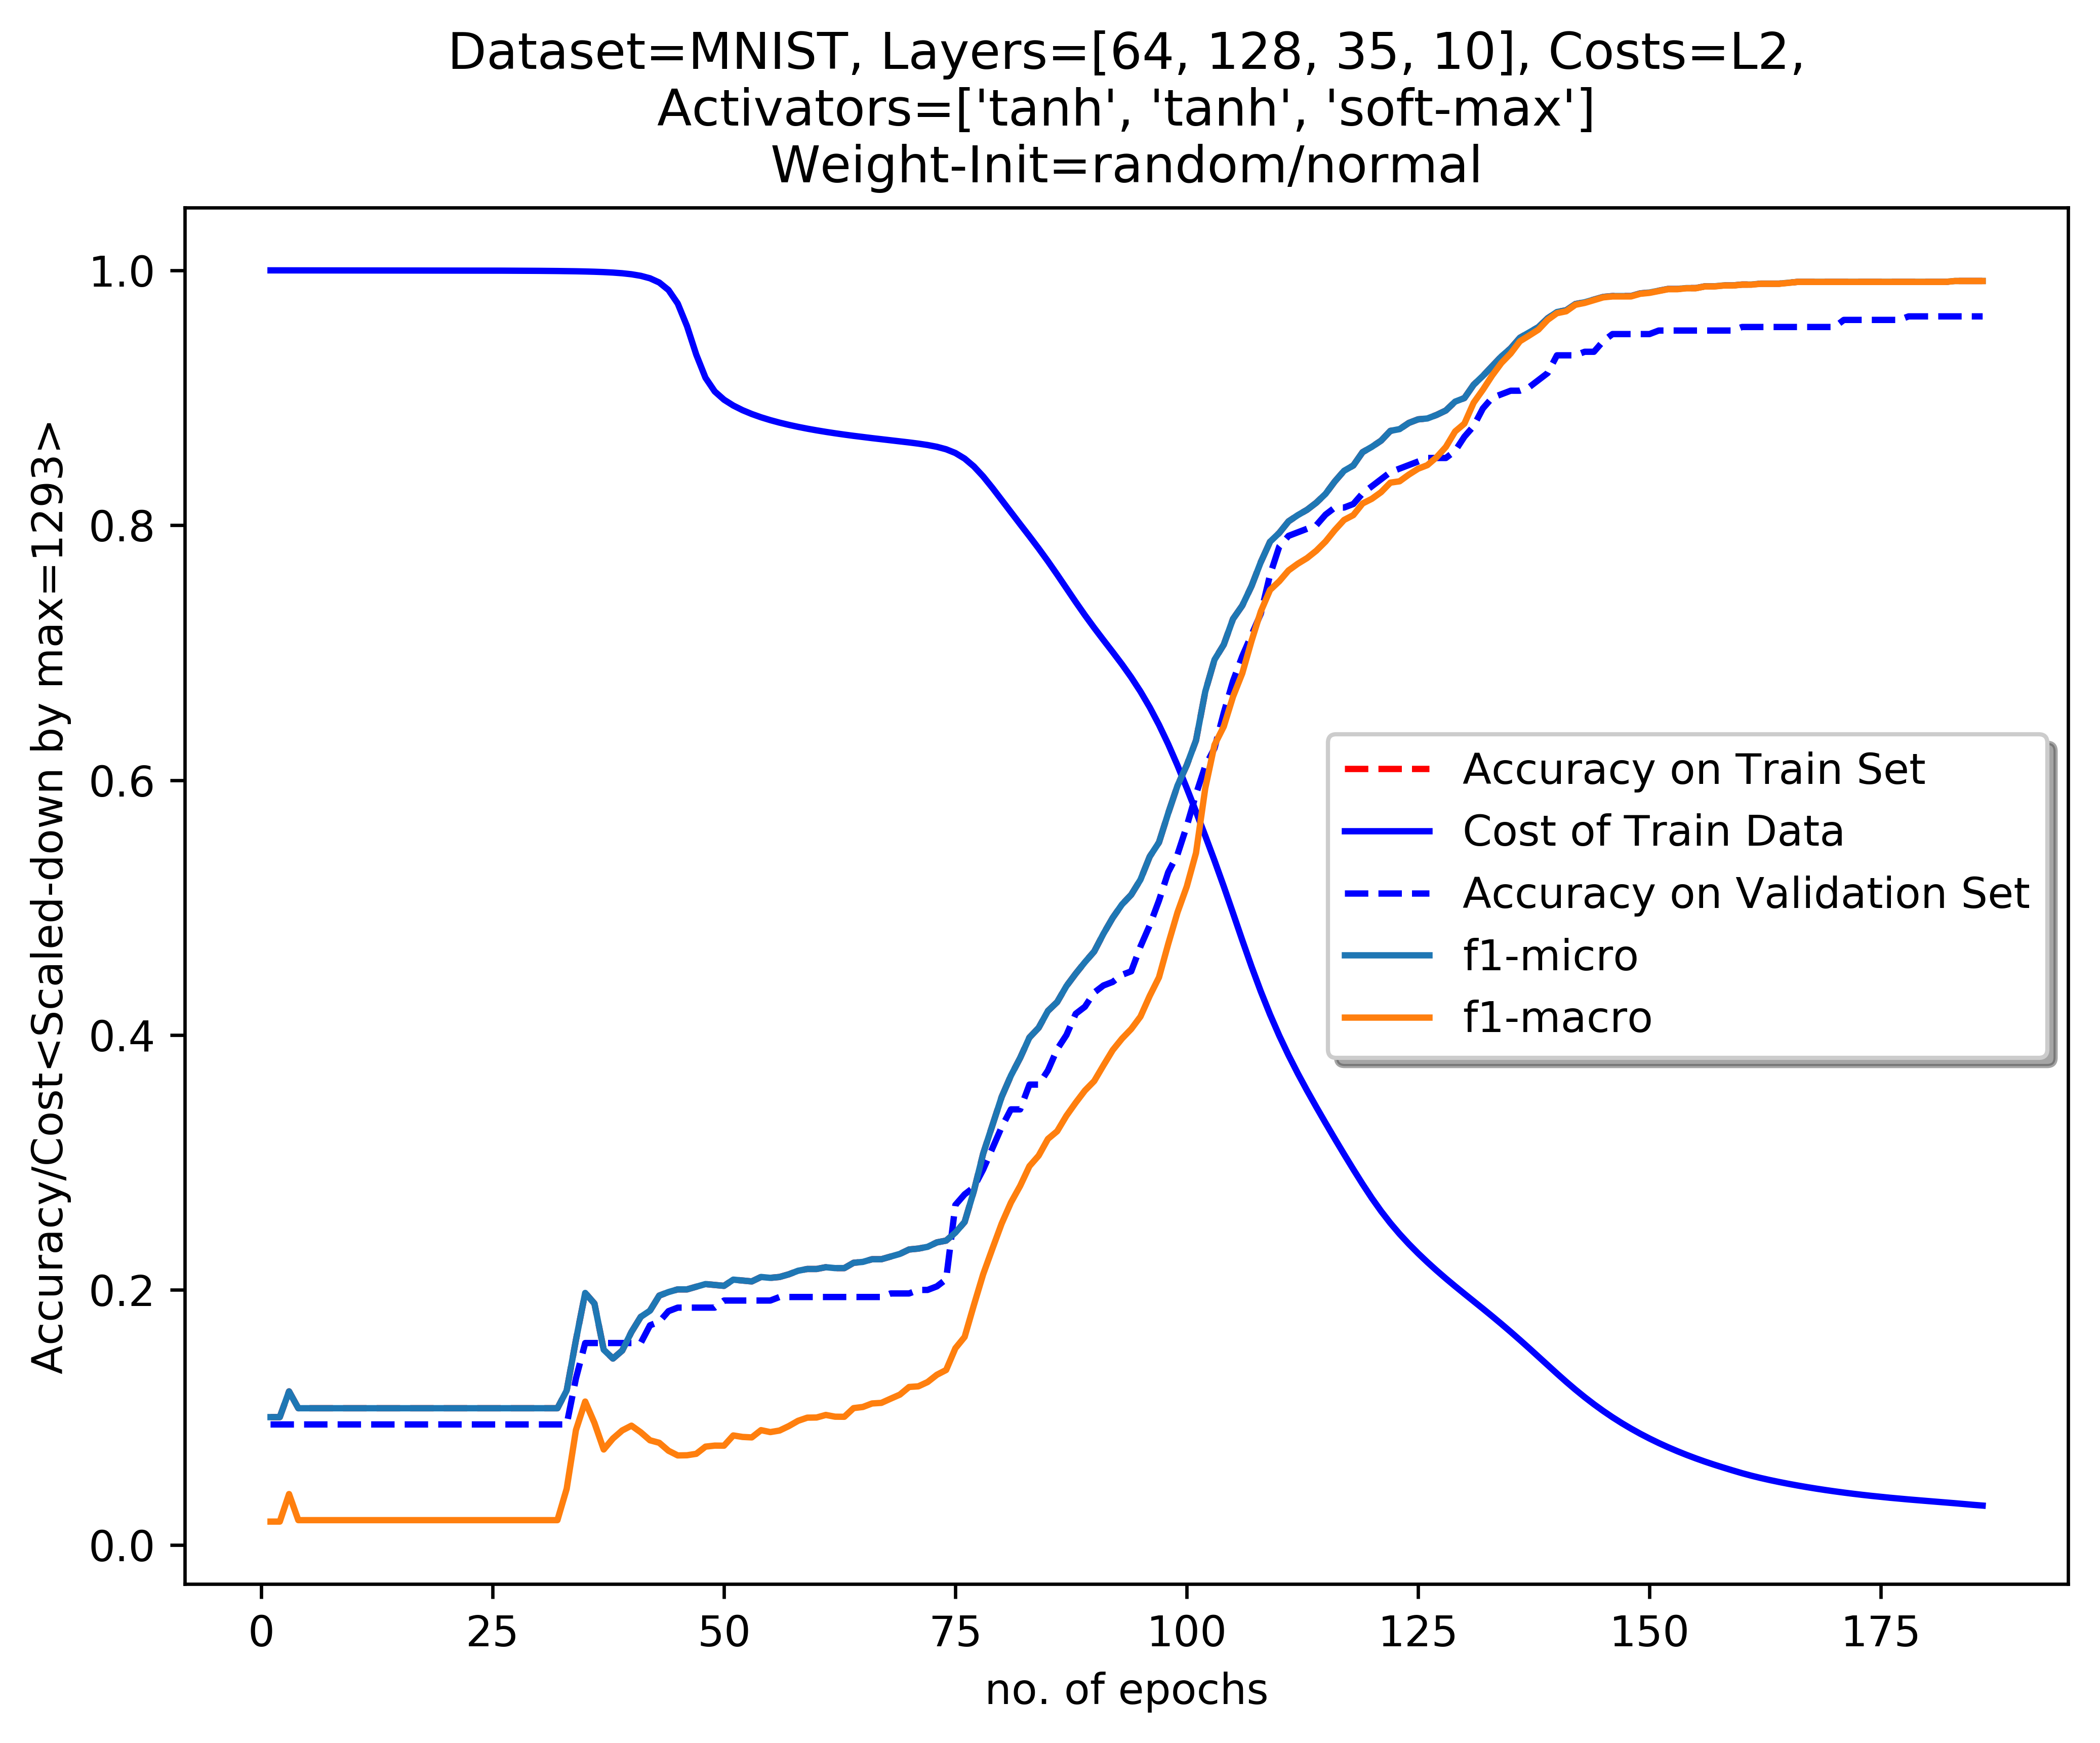

In [15]:
fig_name='myPlot2.png'
plotGraph(net,costs,fig_name)

In [ ]:
len(y_val)

In [ ]:
yp

In [ ]:
(net.classes)

In [ ]:
y_train

In [ ]:
set(y)

In [ ]:
np.mean(np.argmax(y_val,axis=1)==yp)

In [ ]:
y_val

In [ ]:
costs